In [1]:
using Pkg
Pkg.activate("../..")

  Activating project at `~/Documents/repos/nanoOpt.jl`


In [2]:
using Measures,LazyGrids,SpecialFunctions,LaTeXStrings,Plots; pyplot()

Plots.PyPlotBackend()

In [3]:
include("../../src/NanoOpt.jl")

getEfieldInside (generic function with 1 method)

In [4]:
struct miesolver <: Field
    mat1::MaterialParams
    mat2::MaterialParams
    diameter::Number
    lmax::Integer
    
    function miesolver(mat1::MaterialParams,mat2::MaterialParams,diameter::Number,lmax::Integer = 40)
        new(mat1,mat2,diameter,lmax)
    end
end

In [5]:
function riccatibessel(z::Number,ltab::Vector{Int64})
    l = 1:maximum(ltab)

    j₀ = sin(z)/z; j =  √(π/(2*z))*besselj.(l[:].+0.5,z)
    y₀ = -cos(z)/z; y =   √(π/(2*z))*bessely.(l[:].+0.5,z)

    h₀ = j₀ + im*y₀; h = j + im*y
    zjp = z*[j₀; j[1:length(l)-1]]- l[:].*j
    zhp = z*[h₀; h[1:length(l)-1]] - l[:].*h

    j = j[ltab]; zjp = zjp[ltab]
    h = h[ltab]; zhp = zhp[ltab]
    
    j,h,zjp,zhp
end

function miecoefficients(mie::miesolver,k0::Number)
    k₁,Z₁ = mie.mat1.k(k0),mie.mat1.Z(k0)
    k₂,Z₂ = mie.mat2.k(k0),mie.mat2.Z(k0)
    
    z₁,z₂ = 0.5k₁*mie.diameter,0.5k₂*mie.diameter
    
    j₁,_,zjp₁,_ = riccatibessel(z₁,collect(1:mie.lmax))
    j₂,h₂,zjp₂,zhp₂ = riccatibessel(z₂,collect(1:mie.lmax))
    
    a = (Z₂*z₁*j₁.*zjp₂ - Z₁*z₂*j₂.*zjp₁) ./ (Z₂*z₁*j₁.*zhp₂ - Z₁*z₂*h₂.*zjp₁)
    b = (Z₂*z₂*j₂.*zjp₁ - Z₁*z₁*j₁.*zjp₂) ./ (Z₂*z₂*h₂.*zjp₁ - Z₁*z₁*j₁.*zhp₂)
    
    a,b
end

miecoefficients (generic function with 1 method)

In [6]:
mat1 = material(epsdrude("Ag"),1.0)
mat2 = material(2.25,1.0)
diameter = 40.0

40.0

In [7]:
mie = miesolver(mat1,mat2,diameter,40)

λ = collect(LinRange(300,450,200))
k₀ = 2π./λ
z = 0.5*diameter+10.

30.0

## decayrate

In [8]:
k0 = k₀;

In [9]:
totx,totz,radx,radz = zeros(length(k0),length(z)),zeros(length(k0),length(z)),zeros(length(k0),length(z)),zeros(length(k0),length(z))
l = reshape(collect(1:mie.lmax),(:))

for i1 ∈ 1:length(k0)

    k₂ = mie.mat2.k(k0[i1])

    a,b = miecoefficients(mie,k0[i1])

    for i2 ∈ 1:length(z)
        x = k₂*z[i2]
        j,h,ψp,ξp = riccatibessel(x,l)

        radz[i1,i2] = 1.5*sum(l.*(l.+1).*(2*l.+1).*abs.((j + a.*h)/x).^2) 
        radx[i1,i2] = 0.75*sum((2l.+1).*(abs.(j+a.*h).^2+abs.((ψp+b.*ξp)/x).^2))
        totz[i1,i2] = 1 - 1.5*sum(real(l.*(l.+1).*(2*l.+1).*a.*(h/x).^2))
        totx[i1,i2] = 1 - 0.75*sum(real((2l.+1).*(a.*(ξp/x).^2 + b.*h.^2)))
    end
end

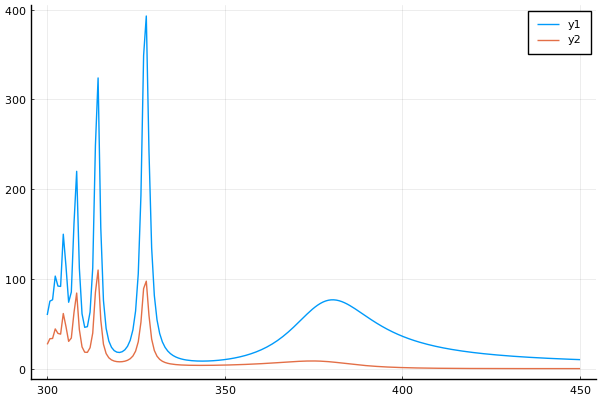

In [10]:
plot(λ,totz[:,1])
plot!(λ,totx[:,1])